## Function to create a list with all the file paths within a path

In [193]:
def getFilePaths(path):
    # Function to return a list of files in a path:
    # Initialize a list for all the file names
    files = list()
    # Look for folders in the list
    for file in os.listdir(path):
        # Concatenate a path for each file
        pathfile = os.path.join(path, file)
        # Validate if the pathfile is a folder
        if os.path.isdir(pathfile):
            files = files + getFilePaths(pathfile)
        else:
            files.append(pathfile)
    return files      

## Create a dataframe with the list of paths

In [194]:
# Import dependencies
import pandas as pd, time, hashlib

In [195]:
# Path with the files to look for duplicates
path='../Photos'
# Initialize and empty dataframe with the paths of the files in the given path
files_df = pd.DataFrame(getFilePaths(path),columns=['path'])
# Initialize Columns for the dataframe 
files_df['hash'] = 0
files_df['filename'] = ''
files_df['count'] = 1
files_df['created'] = 0
files_df['modified'] = 0
files_df['filesize'] = 0

# Loop to fill the dataframe columns with values
for row in range(len(files_df)):
    # Load the file
    image_file = open(files_df['path'][row],'rb').read()
    # Encode the file to a hexagsimal number
    files_df['hash'][row] = hashlib.md5(image_file).hexdigest()
    # Get the filename of the file
    files_df['filename'][row] = os.path.basename(files_df['path'][row])
    # Get the created date 
    files_df['created'][row] = pd.to_datetime(time.ctime(os.path.getctime(files_df['path'][row])))
    # Get the modified date 
    files_df['modified'][row] = pd.to_datetime(time.ctime(os.path.getmtime(files_df['path'][row])))
    # Get file size
    files_df['filesize'][row] = os.path.getsize(files_df['path'][row])
# Print first rows of the dataframe    
files_df.head()

,path,hash,filename,count,created,modified,filesize
0,../Photos/.DS_Store,5f27466e92caf57a930058b683ad5f7e,.DS_Store,1,2020-04-09 18:38:53,2020-04-09 18:38:53,8196
1,../Photos/New Folder With Items 5/DSC_0030.jpg,b8cc4ead5b44bdd8e994c21287e618e8,DSC_0030.jpg,1,2020-04-09 18:38:38,2020-04-07 20:02:04,66724
2,../Photos/New Folder With Items 5/DSC_0024.jpg,683d7efc80e910a2691880ca0ad9d059,DSC_0024.jpg,1,2020-04-09 18:38:38,2020-04-07 19:59:50,66840
3,../Photos/New Folder With Items 5/DSC_0018.jpg,689a4e61ff572cb10ca471fb58004df1,DSC_0018.jpg,1,2020-04-09 18:38:38,2020-04-07 19:54:48,49677
4,../Photos/New Folder With Items 5/DSC_0019.jpg,4d8c40e515d43b15a2dd6f826fdd1163,DSC_0019.jpg,1,2020-04-09 18:38:38,2020-04-07 19:55:54,49553


In [196]:
import numpy as np, datetime
reapeated_files_df = files_df.groupby('hash').sum()
reapeated_files_df = reapeated_files_df[reapeated_files_df['count'] > 1]
pivot_df = pd.pivot_table(reapeated_files_df, values='count', index=['hash'], aggfunc=np.sum, margins=True)
now_string = datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")
pivot_df.to_csv('repeated_' + now_string + '.csv' )
pivot_df

,count
hash,
2ce0738fb3a0787942c97a0c07d25c2c,2
6bcb3dd1f6148d9c388d32953b7a030c,2
933827ccd64bd5345025069ddc79451f,4
ac30e5f00f3a848e6b174b081de267f8,2
cc5e1128d73fa665d69939e6c088da18,2
f67308e65280f43c78398f1c9da6c52d,2
All,14


In [197]:
if pivot_df['count']['All'] ==0:
    print('No repeated files were found')
else:

    repeated_path_df = files_df[files_df['hash'].isin(pivot_df.index.to_list())]
    repeated_path_df = repeated_path_df.groupby(['hash','path','created','modified','filesize']).sum().sort_values(by=['hash',                                                          'created','modified', 'filesize'], ascending=True)
    


    repeated_path_df['action'] = ''
    repeated_path_df['action'][0] = 'leave' 


    for i in range(1,len(repeated_path_df.index.get_level_values(1).tolist())):
        if repeated_path_df.index.get_level_values(0)[i] == repeated_path_df.index.get_level_values(0)[i-1]:
            repeated_path_df['action'][i] = 'delete' 
        else:
            repeated_path_df['action'][i] = 'leave' 
    repeated_path_df.to_csv('repeated_list_' + now_string + '.csv' )
repeated_path_df     

count  \
hash                             path                                               created             modified            filesize          
2ce0738fb3a0787942c97a0c07d25c2c ../Photos/New Folder With Items 4/DSC_0056.jpg     2020-04-09 18:38:32 2020-04-07 20:10:48 70536         1   
                                 ../Photos/New Folder With Items 4/DSC_0056 copy... 2020-04-09 21:05:26 2020-04-07 20:10:48 70536         1   
6bcb3dd1f6148d9c388d32953b7a030c ../Photos/New Folder With Items 4/DSC_0042.jpg     2020-04-09 18:38:32 2020-04-07 20:06:46 68808         1   
                                 ../Photos/New Folder With Items 4/DSC_0042 copy... 2020-04-09 21:05:26 2020-04-07 20:06:46 68808         1   
933827ccd64bd5345025069ddc79451f ../Photos/New Folder With Items/0009845a-53ab-4... 2020-04-09 18:38:09 2020-04-07 15:13:26 211440        1   
                                 ../Photos/New Folder With Items/0009845a-53ab-4... 2020-04-09 18:50:57 2020-04-07 15:13:26 211440        1   
                                 ../Photos/New Folder With Items/0009845a-53ab-4... 2020-04-09 18:50:57 2020-04-07 15:13:26 211440        1   
                                 ../Photos/New Folder With Items/0009845a-53ab-4... 2020-04-09 18:50:58 2020-04-07 15:13:26 211440        1   
ac30e5f00f3a848e6b174b081de267f8 ../Photos/New Folder With Items 4/DSC_0040.jpg     2020-04-09 18:38:32 2020-04-07 20:06:04 72695         1   
                                 ../Photos/New Folder With Items 4/DSC_0040 copy... 2020-04-09 21:05:26 2020-04-07 20:06:04 72695         1   
cc5e1128d73fa665d69939e6c088da18 ../Photos/New Folder With Items 4/DSC_0057.jpg     2020-04-09 18:38:32 2020-04-07 20:11:12 72113         1   
                                 ../Photos/New Folder With Items 4/DSC_0057 copy... 2020-04-09 21:05:26 2020-04-07 20:11:12 72113         1   
f67308e65280f43c78398f1c9da6c52d ../Photos/New Folder With Items 4/DSC_0041.jpg     2020-04-09 18:38:32 2020-04-07 20:06:24 71509         1   
                                 ../Photos/New Folder With Items 4/DSC_0041 copy... 2020-04-09 21:05:26 2020-04-07 20:06:24 71509         1   

                                                                                                                                      action  
hash                             path                                               created             modified            filesize          
2ce0738fb3a0787942c97a0c07d25c2c ../Photos/New Folder With Items 4/DSC_0056.jpg     2020-04-09 18:38:32 2020-04-07 20:10:48 70536      leave  
                                 ../Photos/New Folder With Items 4/DSC_0056 copy... 2020-04-09 21:05:26 2020-04-07 20:10:48 70536     delete  
6bcb3dd1f6148d9c388d32953b7a030c ../Photos/New Folder With Items 4/DSC_0042.jpg     2020-04-09 18:38:32 2020-04-07 20:06:46 68808      leave  
                                 ../Photos/New Folder With Items 4/DSC_0042 copy... 2020-04-09 21:05:26 2020-04-07 20:06:46 68808     delete  
933827ccd64bd5345025069ddc79451f ../Photos/New Folder With Items/0009845a-53ab-4... 2020-04-09 18:38:09 2020-04-07 15:13:26 211440     leave  
                                 ../Photos/New Folder With Items/0009845a-53ab-4... 2020-04-09 18:50:57 2020-04-07 15:13:26 211440    delete  
                                 ../Photos/New Folder With Items/0009845a-53ab-4... 2020-04-09 18:50:57 2020-04-07 15:13:26 211440    delete  
                                 ../Photos/New Folder With Items/0009845a-53ab-4... 2020-04-09 18:50:58 2020-04-07 15:13:26 211440    delete  
ac30e5f00f3a848e6b174b081de267f8 ../Photos/New Folder With Items 4/DSC_0040.jpg     2020-04-09 18:38:32 2020-04-07 20:06:04 72695      leave  
                                 ../Photos/New Folder With Items 4/DSC_0040 copy... 2020-04-09 21:05:26 2020-04-07 20:06:04 72695     delete  
cc5e1128d73fa665d69939e6c088da18 ../Photos/New Folder With Items 4/DSC_0057.jpg     2020-04-09 18:38:32 2020-04-07 20:11:12 72113

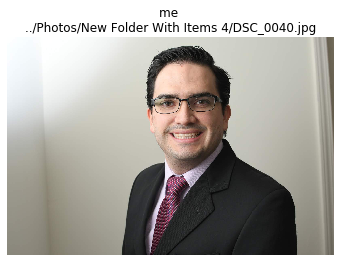

In [198]:
import matplotlib.pyplot as plt, matplotlib.image as mpimg
%matplotlib inline
# was trained with
image_path = os.path.join('../Photos/New Folder With Items 4/DSC_0040.jpg')
plt.title('me \n' + image_path)
plt.axis('off')
img = mpimg.imread(image_path)
plt.imshow(img);

In [199]:
txt = input("Do you want to delete the files(Y/N)?: ")

In [200]:
if pivot_df['count']['All'] ==0:
    print('No repeated files were found')

else:
    if txt == 'Y':
        for i in range(0,len(repeated_path_df.index.get_level_values(1).tolist())):
            if repeated_path_df['action'][i] == 'delete':
                os.remove(repeated_path_df.index.get_level_values(1).tolist()[i])
        print('All duplicated images had been deleted')                
    else:
        print('No files were deleted')



No files were deleted
